*This project focuses on image-to-text generation using a Transformer-based architecture. It extracts image features using a pre-trained ResNet model, which are then processed through a Transformer decoder to generate text. The model incorporates **positional encoding** to handle sequence data and **custom masks** to manage padding and prevent looking ahead during training. The project is trained and evaluated on the **Flickr8k dataset**, where the model learns to generate accurate texts based on image content, with performance tracked via loss and accuracy metrics.*

- **Image Preprocessing**:
  - **ResNet**: Pre-trained for extracting image features.
  - **Transformations**: Images resized to 224x224 and normalized for ResNet input.

- **Text Preprocessing**:
  - **Cleaning**: Tokenized, lowercased, and non-alphabetic characters removed.
  - **Padding**: text padded to a fixed length with `<pad>` token.
  - **Special Tokens**: Added `<start>` and `<end>` for sequence marking.

- **Encoding & Decoding**:
  - **Image Embeddings**: Extracted using ResNet for input to the model.
  - **Transformer Decoder**: Generates text with self-attention mechanisms.
  - **Positional Encoding**: Preserves word order in sequences.
  - **Masked Attention**: Prevents peeking ahead during training.

- **Model Training**:
  - **Training Loop**: Tracks loss and accuracy, uses Adam optimizer.
  - **Checkpointing**: Saves the best model based on validation loss.

This summary provides a clear and quick understanding of the project’s approach to image text.

*Importing all necessary libraries*

---



In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu
pd.set_option('display.max_colwidth', None)

def calculate_bleu_score(reference, hypothesis):
    return sentence_bleu([reference], hypothesis)

*Setting up Kaggle API key and downloading the Flickr8k dataset*

---



In [ ]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)
!kaggle datasets download adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:49<00:00, 22.7MB/s]
100% 1.04G/1.04G [00:49<00:00, 22.6MB/s]


*Extracting the Flickr8k dataset from the ZIP file*

---




In [ ]:
import zipfile
with zipfile.ZipFile('/content/flickr8k.zip', 'r') as zip_ref:
    zip_ref.extractall('flickr8k')
print('Dataset extracted successfully!')

Dataset extracted successfully!


*Loading and displaying the first few rows of the Flickr8k captions dataset*

---



In [ ]:
df = pd.read_csv("/content/flickr8k/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


*Defining a function to remove single-character words from a list*

---



In [ ]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

*Cleaning text by tokenizing, converting to lowercase, and removing single-character words*

---




In [ ]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [ ]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


*Dropping 'seq_len' column and padding text to a fixed sequence length*

---




In [ ]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)))

In [ ]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


*Creating and sorting a frequency distribution of words from the cleaned text*

---



In [ ]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [ ]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [ ]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [ ]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [ ]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [ ]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


*Splitting the dataset into training and validation sets based on the image column*

---




In [ ]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [ ]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


*Calculating the number of training and validation image samples*

---



In [ ]:
train_samples = len(train)
print(train_samples)

36409


In [ ]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


*Defining a custom dataset class to extract image features using ResNet transformations*

---



In [ ]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/flickr8k/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [ ]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)


In [ ]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)


In [ ]:
def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [ ]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [ ]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

*Defining a custom dataset class for loading and processing image-caption pairs with ResNet features*

---



In [ ]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

*Defining a Positional Encoding class for transformer models*

---



In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

*Defining the Image Captioning Model using Transformer architecture with positional encoding and custom masks*


In [ ]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

*Training and evaluation loop for the Image Captioning Model with accuracy tracking and model saving*

---




In [ ]:
EPOCH = 30

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, verbose=True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
# Use float('inf') instead of np.float('Inf')
min_val_loss = float('inf')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    correct_train_predictions = 0
    correct_valid_predictions = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()
        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)
        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 0, 2)
        loss = criterion(output.reshape(-1, vocab_size), target_seq.reshape(-1))
        loss_masked = loss * padding_mask.reshape(-1)
        final_batch_loss = loss_masked.sum() / padding_mask.sum()
        final_batch_loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(output, dim=-1)
        correct_train_predictions += (predictions == target_seq).float().sum().item()
        total_train_words += padding_mask.sum().item()

        total_epoch_train_loss += final_batch_loss.item()

    train_loss = total_epoch_train_loss / total_train_words
    train_losses.append(train_loss)
    train_accuracy = correct_train_predictions / total_train_words
    train_accuracies.append(train_accuracy)

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)
            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 0, 2)
            loss = criterion(output.reshape(-1, vocab_size), target_seq.reshape(-1))
            loss_masked = loss * padding_mask.reshape(-1)
            total_epoch_valid_loss += loss_masked.sum().item()

            # Calculate accuracy
            predictions = torch.argmax(output, dim=-1)
            correct_valid_predictions += (predictions == target_seq).float().sum().item()
            total_valid_words += padding_mask.sum().item()

    valid_loss = total_epoch_valid_loss / total_valid_words
    valid_losses.append(valid_loss)
    valid_accuracy = correct_valid_predictions / total_valid_words
    valid_accuracies.append(valid_accuracy)

    print(f"Epoch -> {epoch}, Training Loss -> {train_loss}, Eval Loss -> {valid_loss}, Train Accuracy -> {train_accuracy}, Eval Accuracy -> {valid_accuracy}")

    # Save the best model
    if min_val_loss > valid_loss:
        print(f"Saving model at epoch {epoch}")
        torch.save(ictModel.state_dict(), './BestModel.pth')
        min_val_loss = valid_loss

    scheduler.step(valid_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch -> 0, Training Loss -> 0.01500153828994791, Eval Loss -> 4.416811705047342, Train Accuracy -> 0.30565956150436824, Eval Accuracy -> 0.30244606203685487
Saving model at epoch 0
Epoch -> 1, Training Loss -> 0.011874548719859868, Eval Loss -> 4.00940238663618, Train Accuracy -> 0.3187471132207121, Eval Accuracy -> 0.33532253481102586
Saving model at epoch 1
Epoch -> 2, Training Loss -> 0.01098170918530893, Eval Loss -> 3.8068504289301073, Train Accuracy -> 0.3415416138447478, Eval Accuracy -> 0.3480228211686012
Saving model at epoch 2
Epoch -> 3, Training Loss -> 0.010432191729874788, Eval Loss -> 3.6782369881110717, Train Accuracy -> 0.35493381290722015, Eval Accuracy -> 0.35770651627429123
Saving model at epoch 3
Epoch -> 4, Training Loss -> 0.010024952171173518, Eval Loss -> 3.588899437522884, Train Accuracy -> 0.3661394302111894, Eval Accuracy -> 0.3664939777471747
Saving model at epoch 4
Epoch -> 5, Training Loss -> 0.00969519088298669, Eval Loss -> 3.5212069316767867, Train Ac

*Most repeated words*

---



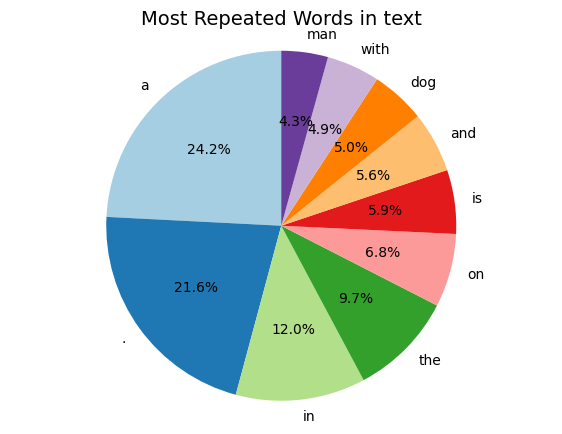

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Read the text from the .txt file
file_path = '/content/flickr8k/captions.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.readlines()

# Tokenize words and count frequencies
all_words = [word.lower() for caption in text for word in caption.split()]
word_counts = Counter(all_words)

# Get the top 10 most common words
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

# Plotting a pie chart
plt.figure(figsize=(7, 5))
plt.pie(counts, labels=words, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Most Repeated Words in text', fontsize=14)
plt.axis('equal')
plt.show()

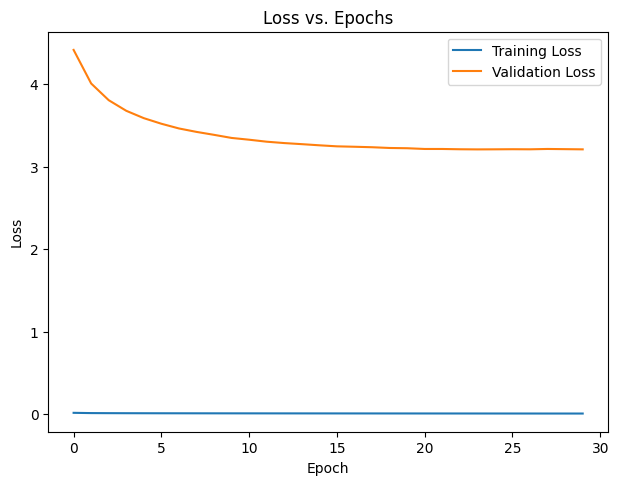

In [ ]:
# Plotting Loss
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.tight_layout()  # Automatically adjust padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Custom padding
plt.show()

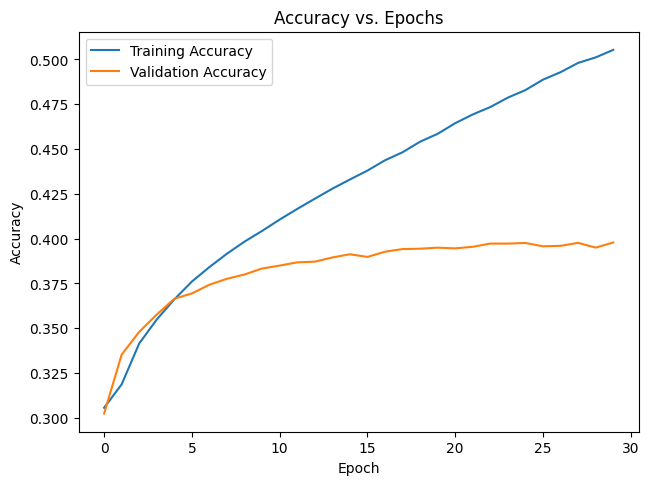

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(7, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.tight_layout()  # Automatically adjust padding
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)  # Custom padding
plt.show()

*Plotting training and validation loss and accuracy over epochs*

In [ ]:
model = torch.load('/content/BestModel.pth')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


<ipython-input-42-0455b4fefddc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/BestModel.pth')


In [ ]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [ ]:
def generate_text(K, img_nm):
    img_loc = '/content/flickr8k/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual text : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted text : ")
    print(" ".join(predicted_sentence+['.']))

In [ ]:
# Instantiate the model
model = ImageCaptionModel(16, 4, vocab_size, 512).to(device)

# Load the state dictionary with strict=False to ignore size mismatch
# This will load the matching keys and skip any mismatched keys.
# Note: This may result in unexpected behavior if the model architectures are significantly different.
state_dict = torch.load('BestModel.pth')

# Get the state dict of the current model
current_state_dict = model.state_dict()

# Filter out keys with mismatched shapes
# Only keep keys where the shapes in the loaded state dict match the current model's state dict
filtered_state_dict = {k: v for k, v in state_dict.items() if k in current_state_dict and v.size() == current_state_dict[k].size()}

# Update the current state dict with the filtered loaded state dict
current_state_dict.update(filtered_state_dict)
model.load_state_dict(current_state_dict, strict=False)

# Set the model to evaluation mode
model.eval()

<ipython-input-45-c21bf8dd4d34>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('BestModel.pth')


ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): Transfor

*Testing...*

---



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Actual text : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted text : 
little girl in pink shirt is jumping on playground equipment .


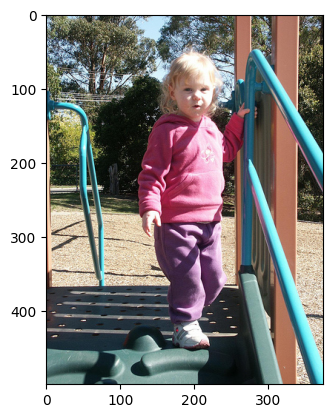

In [ ]:
generate_text(1, unq_valid_imgs.iloc[50]['image'])

Actual text : 
['Young child in pink top and purple pants clutching a turquoise guard rail .', 'A very young girl is walking on a playground .', 'The little girl is playing at the playground .', 'A little girl in pink and purple stands on a playground .', 'A female toddler wearing a pink shirt is playing on a playground .']


Predicted text : 
little girl in blue shirt is jumping over playground .


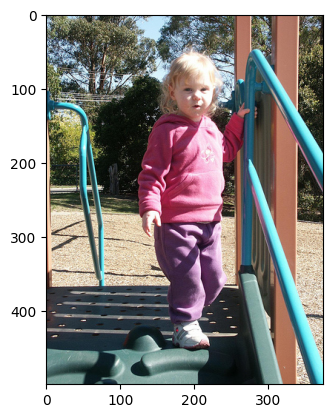

In [ ]:
generate_text(2, unq_valid_imgs.iloc[50]['image'])

*Test - 02*

Actual text : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted text : 
man is standing on rock overlooking the side of mountain .


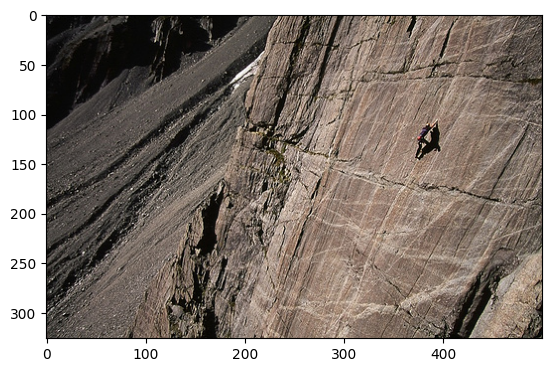

In [ ]:
generate_text(1, unq_valid_imgs.iloc[100]['image'])

Actual text : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted text : 
person in red shirt and black coat is standing in front .


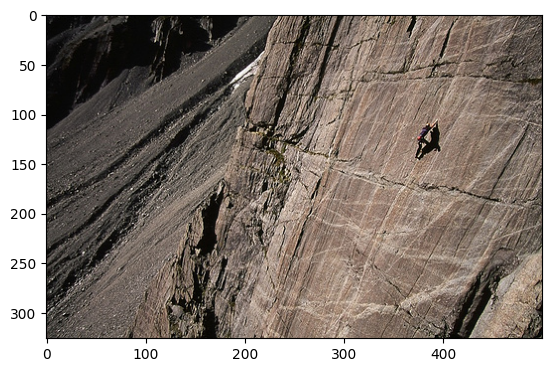

In [ ]:
generate_text(2, unq_valid_imgs.iloc[100]['image'])

*Test - 03*

Actual text : 
['A curly haired dog tries to bite another dog wearing a green and orange collar .', 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .', 'Two brown dogs playing .', 'Two dogs , one with its mouth open .', 'Two golden dogs playing with one another']


Predicted text : 
brown dog is laying in the grass with its tongue hanging out .


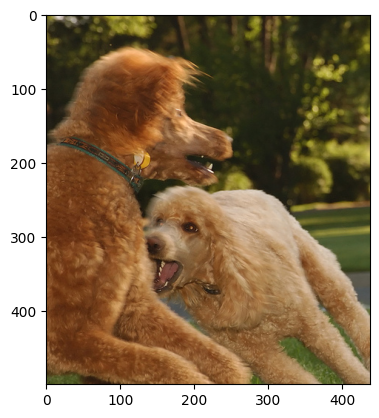

In [ ]:
generate_text(1, unq_valid_imgs.iloc[500]['image'])

Actual text : 
['A curly haired dog tries to bite another dog wearing a green and orange collar .', 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .', 'Two brown dogs playing .', 'Two dogs , one with its mouth open .', 'Two golden dogs playing with one another']


Predicted text : 
brown dog and black dog are in the snow .


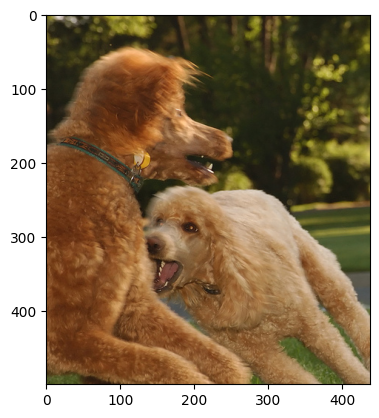

In [ ]:
generate_text(2, unq_valid_imgs.iloc[500]['image'])

*Test - 04*

Actual text : 
['The dog has his tongue sticking out and walking in the grass .', 'Brown and white dog runs at camera over grass .', 'A spaniel runs through the grass .', 'A brown dog with very floppy ears runs through a field of emerald grass .', 'A fluffy dog in grass .']


Predicted text : 
brown dog is running through the grass .


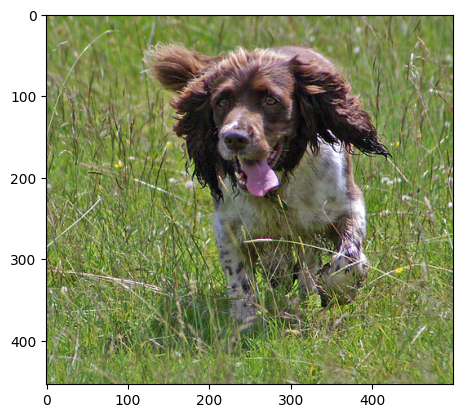

In [ ]:
generate_text(1, unq_valid_imgs.iloc[600]['image'])

Actual text : 
['The dog has his tongue sticking out and walking in the grass .', 'Brown and white dog runs at camera over grass .', 'A spaniel runs through the grass .', 'A brown dog with very floppy ears runs through a field of emerald grass .', 'A fluffy dog in grass .']


Predicted text : 
brown dog is running through field .


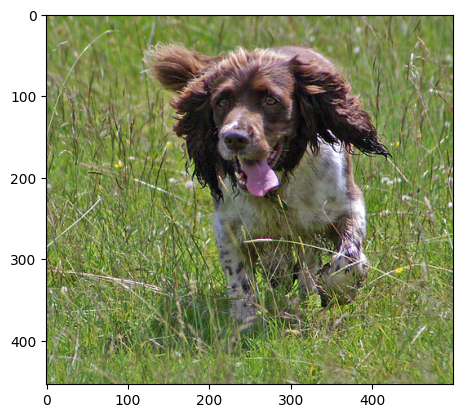

In [ ]:
generate_text(2, unq_valid_imgs.iloc[600]['image'])